# Weather Data Analysis 

### Let's import flow data.csv file and see what information it contains 

In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pylab as plt
import matplotlib.pyplot as plt

In [93]:
flow_data = pd.read_csv('flow data.csv')
flow_data.head(5)

﻿Daily Discharge (m3/s) (PARAM = 1) and Daily Water Level (m) (PARAM = 2)
ID      PARAM Date       Value                                                SYM                       
02HC027 1     1966/07/04 0.357                                                NaN                       
              1966/07/05 0.249                                                NaN                       
              1966/07/06 0.275                                                NaN                       
              1966/07/07 0.337                                                NaN

### It looks like first row of the csv changes the structure of the dataframe (Daily Discharge (m3/s) (PARAM = 1) and Daily Water Level (m) (PARAM = 2)). Hence, we should drop it when downloading. 

In [94]:
flow_data = pd.read_csv('flow data.csv', skiprows=1)


In [95]:
flow_data.head(5)

,ID,PARAM,Date,Value,SYM
0,02HC027,1,1966/07/04,0.357,NaN
1,02HC027,1,1966/07/05,0.249,NaN
2,02HC027,1,1966/07/06,0.275,NaN
3,02HC027,1,1966/07/07,0.337,NaN
4,02HC027,1,1966/07/08,0.252,NaN


### Now we will create two new dataframes each for daily discharge and for daily water level and merge them 

In [96]:
flow_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58712 entries, 0 to 58711
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      58712 non-null  object 
 1   PARAM   58712 non-null  int64  
 2   Date    58712 non-null  object 
 3   Value   58630 non-null  float64
 4   SYM     3829 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 2.2+ MB


In [97]:
flow_data.describe()

,PARAM,Value
count,58712.000000,58630.000000
mean,1.267492,3.475399
std,0.442655,4.926985
min,1.000000,0.042000
25%,1.000000,0.355000
50%,1.000000,1.540000
75%,2.000000,3.720000
max,2.000000,108.000000


In [98]:
# Create separate DataFrames for PARAM = 1 and PARAM = 2
param_1_data = flow_data[flow_data["PARAM"] == 1][["ID", "Date", "SYM", "Value"]].rename(columns={"Value": "daily_discharge"})
param_2_data = flow_data[flow_data["PARAM"] == 2][["ID", "Date", "SYM", "Value"]].rename(columns={"Value": "water_level"})

# Merge the two DataFrames on ID, Date, and SYM
flow_data_merged = pd.merge(param_1_data, param_2_data, on=["ID", "Date", "SYM"], how="outer")


In [99]:
flow_data_merged

,ID,Date,SYM,daily_discharge,water_level
0,02HC027,1966/07/04,NaN,0.357,NaN
1,02HC027,1966/07/05,NaN,0.249,NaN
2,02HC027,1966/07/06,NaN,0.275,NaN
3,02HC027,1966/07/07,NaN,0.337,NaN
4,02HC027,1966/07/08,NaN,0.252,NaN
...,...,...,...,...,...
44497,02HC024,2022/08/12,A,NaN,12.090
44498,02HC024,2022/08/13,NaN,NaN,NaN
44499,02HC024,2022/08/14,NaN,NaN,NaN
44500,02HC024,2022/08/15,NaN,NaN,NaN


In [100]:
flow_data_merged.describe()

,daily_discharge,water_level
count,43007.000000,15623.000000
mean,2.504642,6.147701
std,4.108611,5.907381
min,0.042000,0.199000
25%,0.370000,0.341000
50%,1.550000,0.855000
75%,2.700000,12.166000
max,108.000000,13.541000


In [101]:
# Convert the 'Date' column to datetime format
flow_data_merged["Date"] = pd.to_datetime(flow_data_merged["Date"])
flow_data_merged = flow_data_merged.sort_values(by="Date").reset_index(drop=True)


# Verify the changes
print(flow_data_merged.info())  # Confirm that the 'Date' column is now datetime
print(flow_data_merged.head())  # Inspect the first few rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44502 entries, 0 to 44501
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               44502 non-null  object        
 1   Date             44502 non-null  datetime64[ns]
 2   SYM              3790 non-null   object        
 3   daily_discharge  43007 non-null  float64       
 4   water_level      15623 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 1.7+ MB
None
        ID       Date  SYM  daily_discharge  water_level
0  02HC024 1962-10-01  NaN             2.15          NaN
1  02HC024 1962-10-02  NaN             1.98          NaN
2  02HC024 1962-10-03  NaN             1.87          NaN
3  02HC024 1962-10-04  NaN             1.87          NaN
4  02HC024 1962-10-05  NaN             6.37          NaN


In [ ]:
# Check for duplicates in ID, Date
duplicates = flow_data_merged.duplicated(subset=["ID", "Date", ])
print(flow_data_merged[duplicates])

Empty DataFrame
Columns: [ID, Date, SYM, daily_discharge, water_level]
Index: []


In [103]:
flow_data_merged = flow_data_merged.drop_duplicates()
flow_data_merged

,ID,Date,SYM,daily_discharge,water_level
0,02HC024,1962-10-01,NaN,2.15,NaN
1,02HC024,1962-10-02,NaN,1.98,NaN
2,02HC024,1962-10-03,NaN,1.87,NaN
3,02HC024,1962-10-04,NaN,1.87,NaN
4,02HC024,1962-10-05,NaN,6.37,NaN
...,...,...,...,...,...
44497,02HC027,2023-12-27,NaN,3.79,0.693
44498,02HC027,2023-12-28,NaN,1.83,0.680
44499,02HC027,2023-12-29,NaN,1.85,0.622
44500,02HC027,2023-12-30,NaN,1.31,0.575


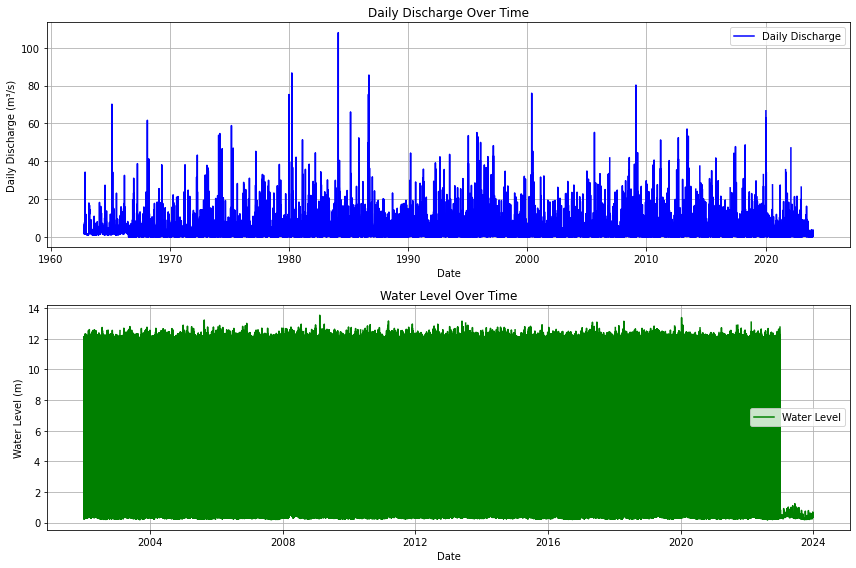

In [87]:
plt.figure(figsize=(12, 8))

# Subplot 1: Daily Discharge
plt.subplot(2, 1, 1)  # 2 rows, 1 column, subplot 1
plt.plot(flow_data_merged["Date"], flow_data_merged["daily_discharge"], label="Daily Discharge", color="blue")
plt.xlabel("Date")
plt.ylabel("Daily Discharge (m³/s)")
plt.title("Daily Discharge Over Time")
plt.grid(True)
plt.legend()

# Subplot 2: Water Level
plt.subplot(2, 1, 2)  # 2 rows, 1 column, subplot 2
plt.plot(flow_data_merged["Date"], flow_data_merged["water_level"], label="Water Level", color="green")
plt.xlabel("Date")
plt.ylabel("Water Level (m)")
plt.title("Water Level Over Time")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
